In [1]:
import numpy as np
import itk
import matplotlib.pyplot as plt
import random

In [9]:
tubevol = itk.imread("/d/data/VesselImages/HeadMRA/Aylward-M1-S2-Identity.mha")
#tubevol = itk.imread("/Users/hasti/Documents/avm_resampled.mha")
#tubevol = itk.imread("/d/tubetk/build64/ExternalData/data_keys/Branch.n010.mha")
tubevol = itk.CastImageFilter[itk.Image[itk.SS, 3], itk.Image[itk.F, 3]].New()(tubevol)


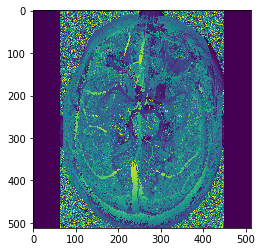

dtype('float32')

In [10]:
v = itk.GetArrayFromImage(tubevol)
j = 0
plt.imshow(np.argmax(v, j))
plt.show()
v.dtype

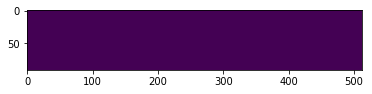

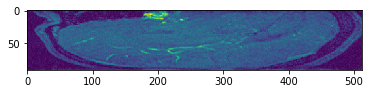

In [11]:
plt.imshow(v[:,: , 50])
plt.show()
plt.imshow(v[:,: , 250])
plt.show()

In [12]:
import itk
def scale_for_image(components):
    return np.array(255. * (components - np.min(components)) / (np.max(components) - np.min(components)), dtype=np.uint8)

def writeVolume(nparray, name):
    ImageType = itk.Image[itk.UC, 3]
    ReaderType = itk.ImageFileReader[ImageType]
    #buff = itk.BridgeNumPy.PyBuffer[ImageType]
    x = scale_for_image(nparray).copy() # necessary to store x in a named variable so it isn't deleted, since Im will be a view
    Im = itk.GetImageFromArray(x)
    Im.Update()
    #print Im
    WriterType = itk.ImageFileWriter[ImageType]
    writer = WriterType.New()
    writer.SetInput(Im)
    writer.SetFileName(name)
    writer.Update()

In [13]:
def tkshow(i):
    z = itk.GetArrayFromImage(i)
    if len(z.shape) == 2:
        plt.imshow(z)
    else:
        plt.imshow(np.max(z, 0))
        plt.colorbar()
        plt.show()
        plt.imshow(np.max(z, 1))
        plt.colorbar()
        plt.show()
        plt.imshow(np.max(z, 2))
        plt.colorbar()
    plt.show()
    
def itk_pos_to_array(itkpos):
    return [itkpos.GetElement(i) for i in range(3)]

def spatial_object_pt_to_radius(pt):
    #forgive me
    return float(str(pt).split("R: ")[1].split("\n")[0])

In [14]:
r = tubevol.GetLargestPossibleRegion()
r.IsInside([50, 5660, 50])

False

In [28]:
tuber = itk.TubeTK.SegmentTubes[itk.Image[itk.F, 3]].New()
tubecounter = 0


tuber.SetInputImage(tubevol)
tuber.SetRadius(2)

In [29]:


#pos = [264, 176, 28]
pos = [200, 183, 15] #stephen seed
#pos = [255, 151, 45]
#pos = [50, 32, 83]
#pos = [2 * 61, 2 * 101, 2 * 61]
def segment(pos):
    if not(tubevol.GetLargestPossibleRegion().IsInside([int(i) for i in pos])):
        print("ded")
        return
    global tubecounter
    print(".", end="")
    atube = tuber.ExtractTube(pos, tubecounter, True)
    print("-", end="")
    thistube = tubecounter
    tubecounter += 1
    #atube = tuber.ExtractTube([30, 50, 30], 0, True)
    if atube and atube.GetNumberOfPoints() > 150:
        tuber.AddTube(atube)

        #btube = tuber.ExtractTube([50, 32, 83], 0, True)
        #btube = tuber.ExtractTube([255, 151, 45], 1, True)
        #if(btube):
        #    tuber.AddTube(btube)

        """
        out = np.zeros(tubevol.GetLargestPossibleRegion().GetSize())
        for i in range(out.shape[0]):
            for j in range(out.shape[1]):
                for k in range(out.shape[2]):
                    out[i, j, k] = btube.Evaluate([i, j, k])
        plt.imshow(np.max(out, 0))
        plt.show()
        """



        flyer = itk.TubeTK.ComputeTubeFlyThroughImage[itk.F, 3].New()

        flyer.SetInput(tuber.GetTubeGroup())
        flyer.SetInputImage(tubevol)
        flyer.SetTubeId(atube.GetId())
        flyer.Update()

        x = flyer.GetOutput()

        import cv2
        xx = itk.GetArrayFromImage(x)
        '''for i, sheet in enumerate(xx[::500]):
            print(i)
            plt.imshow(sheet + 3)
            plt.show()
       '''

        shorten = 1

        xy = xx[::shorten]
        def getNormal1(pt):
            return [float(a) for a in str(pt).split("Normal1: [")[1].split("]")[0].split(", ")]
        def getNormal2(pt):
            return [float(a) for a in str(pt).split("Normal2: [")[1].split("]")[0].split(", ")]


        def idx_like(array):
            return np.mgrid[0:array.shape[0]:1, 0:array.shape[1]:1, 0:array.shape[2]:1]
        xi, yi, zi = idx_like(xy)
        xi *= shorten
        zi = zi - xx.shape[1] / 2 + .5
        yi = yi - xx.shape[1] / 2 + .5

        def outside(xy):
            return np.concatenate([xy[:, 0], xy[:, :, -1], xy[:, -1, ::-1], xy[:, ::-1, 0]], 1).transpose()

        xi = outside(xi)
        yi = outside(yi)
        zi = outside(zi)
        '''
        plt.imshow(outside(xy))    
        plt.axis("equal")
        plt.colorbar()
        plt.show()
        l = 2
        plt.imshow(outside(xy[:, l:-l, l:-l]))    
        plt.axis("equal")
        plt.colorbar()
        plt.show()

        '''

        o = outside(xy)
        high = o > np.max(xx) * .35
        #plt.imshow(high)
        #plt.show()

        import scipy.ndimage

        dialated = scipy.ndimage.morphology.grey_dilation(o, size=(7, 7))
        localmax = o == dialated

        #plt.imshow(localmax)
        #plt.show()
        #plt.imshow(np.logical_and(high, localmax)[:, :])
        #plt.show()

        seeds = np.logical_and(high, localmax)[:, :]

        seeds = seeds

        xi = xi[seeds]
        yi = yi[seeds]
        zi = zi[seeds]
        #plt.scatter(xi, yi)

        #plt.show()

        canidates = []
        centers = []
        for i in range(len(zi)):
            pt = atube.GetPoint(int(xi[i]))
            center = np.array(itk_pos_to_array(pt.GetPosition()))
            centers.append(center)
            normal1 = np.array(getNormal1(pt))
            normal1 = normal1 / np.linalg.norm(normal1)
            normal2 = np.array(getNormal2(pt))
            normal2 = normal2 / np.linalg.norm(normal2)

            normal1 = normal1 * zi[i]
            normal2 = normal2 * yi[i]

            canidates.append(center + normal1 + normal2)
        
        
        for center in [centers[0], centers[-1]]:
            for _ in range(4):
                canidates.append([
                    center[0] + random.uniform(-5, 5),
                    center[1] + random.uniform(-5, 5),
                    center[2] + random.uniform(-5, 5),
                ])


        #print(canidates)
        canidates = np.array(canidates)
        centers = np.array(centers)

        #plt.scatter(centers[:, 0], centers[:, 1])
        #plt.scatter(canidates[:, 0], canidates[:, 1])
        #plt.show()
        #z = tuber.GetTubeMaskImage()

        #tkshow(z)
        for canidate in canidates:
            
            segment(list(canidate))
%prun segment(pos)



.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

In [ ]:
tube_py = []



for j in range(atube.GetNumberOfPoints()):
    pt = atube.GetPoint(j)
    pos = itk_pos_to_array(pt.GetPosition())
    radius = spatial_object_pt_to_radius(pt)
    tube_py.append({'point': pos, 'radius': radius},)
print(len(tube_py))

In [24]:

z2 = tuber.GetTubeMaskImage()

z2 = itk.GetArrayFromImage(z2)
z2 = z2 != 0

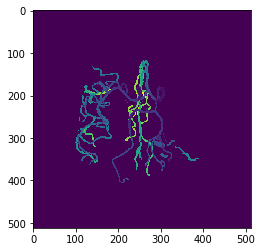

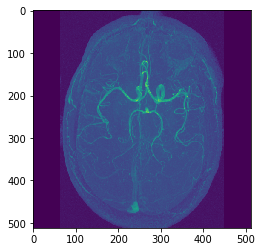

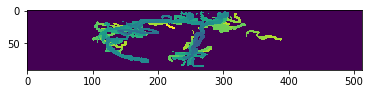

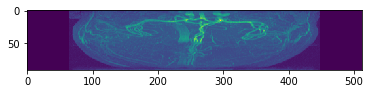

In [25]:
nvol = itk.GetArrayFromImage(tubevol).copy()
plt.imshow(np.argmax(z2, 0))
plt.show()
plt.imshow(np.max(nvol, 0))
plt.show()

plt.imshow(np.argmax(z2, 1))
plt.show()
plt.imshow(np.max(nvol, 1))
plt.show()

In [20]:
import random
random.uniform(-10, 10)

3.4540592326156236

In [21]:
import itk

In [83]:
x = tuber.GetTubeGroup()

In [84]:
z = x.GetChildren()
z.size()

1

In [34]:
np.argmax(nvol)

4042023

In [21]:
tuber.GetRadius()

2.0

In [15]:
tuber

<tubeSegmentTubesPython.tubeSegmentTubesIF3; proxy of <Swig Object of type 'tubeSegmentTubesIF3 *' at 0x0000026E146D32A0> >

In [47]:
tubewriter = itk.SpatialObjectWriter[3].New()

In [48]:
tubewriter.SetInput(x)

In [49]:
tubewriter.SetFileName("avmbraintubes.meta")

In [50]:
tubewriter.Update()

In [33]:
writeVolume(z2 * 1, "avmtubeimage.mha")

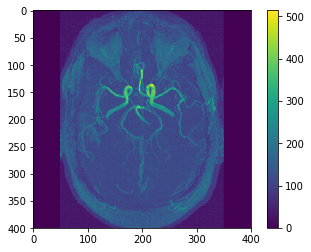

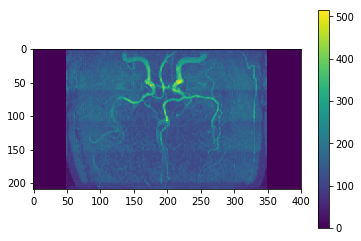

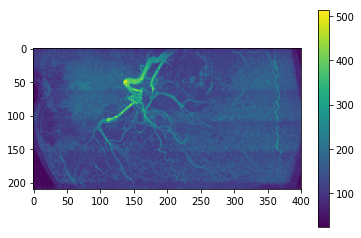

In [14]:
tkshow(tubevol)